In [2]:
import os
import pandas as pd

base_dir = "/Users/sofiehultengren/Desktop/Kandidat speciale /Slicer analysis /Pig_1"

rows = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(".tsv"):
            file_path = os.path.join(root, file)

            df = pd.read_csv(file_path, sep="\t")

            # Antag at TSV'en kun har én række
            row = df.iloc[0].copy()

            # Brug filnavn (uden .tsv) som index
            row.name = os.path.splitext(file)[0]

            rows.append(row)

# Saml til én tabel
final_df = pd.DataFrame(rows)

display(final_df)


,Segment,Voxel count,Volume mm3,Volume cm3
Pig1_release_30%_1,LV,252128,46835.5,46.8355
Pig1_release_0%_1,LV_release,394012,73192.1,73.1921
Pig1_Baseline_30%_1,LV,232075,43110.5,43.1105
Pig1_baseline_0%_1,LV,411985,76530.7,76.5307
Pig1_INAP_30%_1,LV,184286,34233.2,34.2332
Pig1_INAP_0%_1,LV_Apnø,292017,54245.4,54.2454


In [3]:
df = final_df.drop(columns=["Segment"])
df = df.drop(columns=['Voxel count'])
df = df.drop(columns=['Volume mm3'])
df = df.rename(columns={'Volume cm3': 'Volume (mL)'})
display(df)


,Volume (mL)
Pig1_release_30%_1,46.8355
Pig1_release_0%_1,73.1921
Pig1_Baseline_30%_1,43.1105
Pig1_baseline_0%_1,76.5307
Pig1_INAP_30%_1,34.2332
Pig1_INAP_0%_1,54.2454


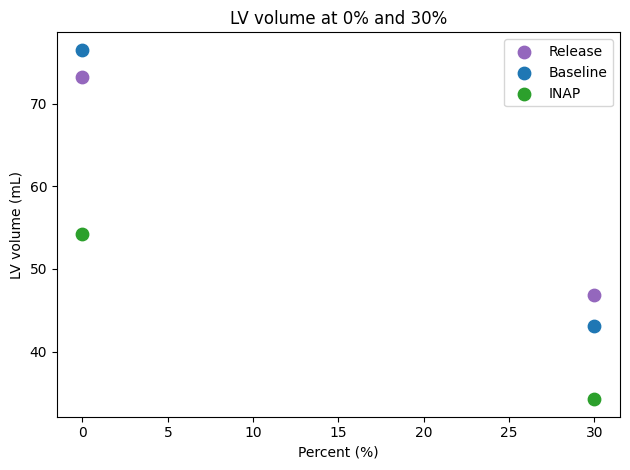

In [5]:
import re
import pandas as pd
import matplotlib.pyplot as plt

vol_col = "Volume (mL)"

plot_df = df.copy()
plot_df = plot_df.reset_index().rename(columns={"index": "name"})

def parse_name(s):
    s_low = s.lower()
    if "baseline" in s_low:
        cond = "Baseline"
    elif "inap" in s_low:
        cond = "INAP"
    elif "release" in s_low:
        cond = "Release"
    else:
        cond = "Other"
    m = re.search(r"_(\d+)%", s)
    pct = int(m.group(1)) if m else None
    return cond, pct

plot_df[["Condition", "Percent"]] = plot_df["name"].apply(
    lambda x: pd.Series(parse_name(x))
)

plot_df = plot_df.dropna(subset=["Percent"])

# Farver pr. condition
colors = {
    "Baseline": "tab:blue",
    "INAP": "tab:green",
    "Release": "tab:purple"
}

plt.figure()

for cond in plot_df["Condition"].unique():
    sub = plot_df[plot_df["Condition"] == cond]
    plt.scatter(
        sub["Percent"],
        sub[vol_col],
        label=cond,
        color=colors.get(cond, "gray"),
        s=80
    )

plt.xlabel("Percent (%)")
plt.ylabel("LV volume (mL)")
plt.title("LV volume at 0% and 30%")
plt.legend()
plt.tight_layout()
plt.show()


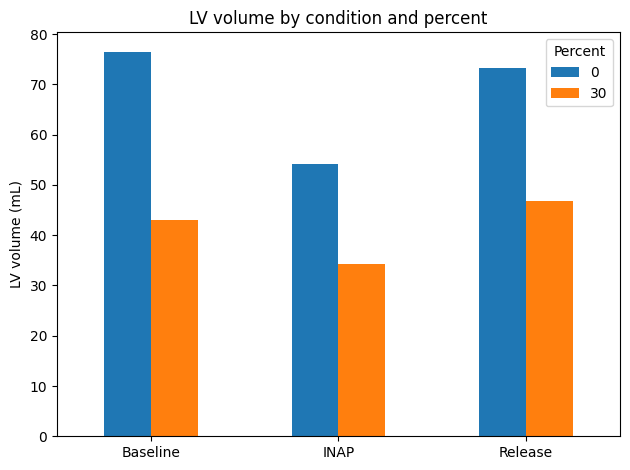

In [18]:
import matplotlib.pyplot as plt

pivot = plot_df.pivot_table(index="Condition", columns="Percent", values=vol_col, aggfunc="mean")
pivot = pivot.reindex(["Baseline", "INAP", "Release"])

ax = pivot.plot(kind="bar")
ax.set_xlabel("")
ax.set_ylabel("LV volume (mL)")
ax.set_title("LV volume by condition and percent")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


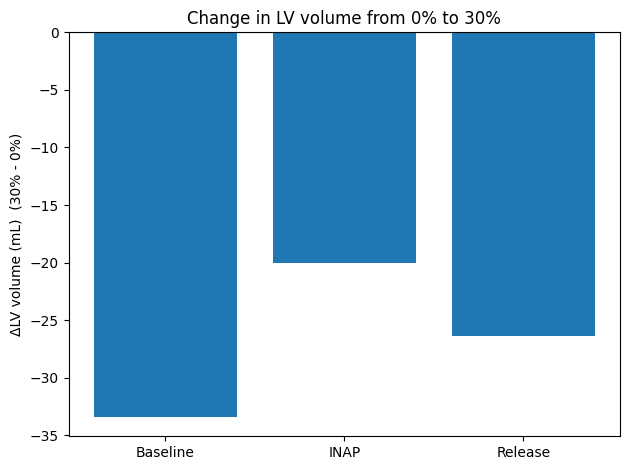

In [19]:
diff = pivot[30] - pivot[0]

plt.figure()
plt.bar(diff.index, diff.values)
plt.axhline(0)
plt.ylabel("ΔLV volume (mL)  (30% - 0%)")
plt.title("Change in LV volume from 0% to 30%")
plt.tight_layout()
plt.show()
